Research Question: What is the probability of winning a single round of Blackjack when following a fixed strategy of hitting until the player's sum is 17 or greater, and how does the empirical probability compare to theoretical expectations (including a binomial-style comparison for multiple rounds)?

Study Design and Simulation Description
Random variable(s): Each game's outcome, quantified as Win (+1), Draw (0), or Loss (-1).

One trial:

Player and dealer are dealt initial cards; the dealer shows one card face-up.

Player follows the strategy: hit while player sum < 17, otherwise stick.

Dealer draws according to standard rules: hit until dealer sum ≥ 17.

Trial ends when reward is returned (+1/0/-1).

Assumptions:

Cards are drawn from an infinite deck (sampling with replacement).

No doubling down, splitting, or betting adjustments are considered.

Natural Blackjack rules are disabled (natural=False, sab=False) for reproducibility.

Each trial is independent.

1,000 trials are simulated to ensure convergence of empirical probabilities.

Analysis Plan:

Record counts of wins, draws, and losses.

Compute empirical probabilities, expected value, and standard deviation of rewards.

Generate cumulative win-rate plots to visualize convergence (Law of Large Numbers).

Compare to literature-based single-game probabilities (≈0.42).

Compute binomial probabilities for composite events (e.g., P(win ≥ 6 of 10)) using both theoretical and empirical probabilities to analyze session-level outcomes.

The simulation allows practical estimation of probabilities given the conditional complexity of Blackjack, while the cumulative plots illustrate the effect of repeated trials on expected outcomes.

=== Demo rounds (text output) ===

Demo Game 1
Player sum: 18, Dealer shows: 10, Usable ace: 1, Action: Stick
Result: LOSS

Demo Game 2
Player sum: 16, Dealer shows: 6, Usable ace: 1, Action: Hit
Player sum: 12, Dealer shows: 6, Usable ace: 0, Action: Hit
Result: LOSS

Demo Game 3
Player sum: 16, Dealer shows: 10, Usable ace: 0, Action: Hit
Result: LOSS

Demo Game 4
Player sum: 21, Dealer shows: 1, Usable ace: 1, Action: Stick
Result: DRAW

Demo Game 5
Player sum: 20, Dealer shows: 10, Usable ace: 0, Action: Stick
Result: DRAW

=== Simulation Summary ===
Trials: 1000
Wins: 425, Draws: 107, Losses: 468
Empirical probabilities - Win: 0.425, Draw: 0.107, Loss: 0.468
Expected value (mean reward per game): -0.043
Standard deviation of rewards: 0.944

Theoretical (literature) single-game win prob: 0.420
P(win >= 6 of 10) using literature p=0.420: 0.202
P(win >= 6 of 10) using empirical p=0.425: 0.211


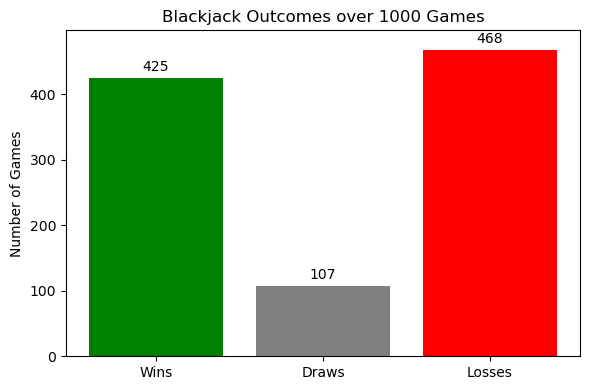

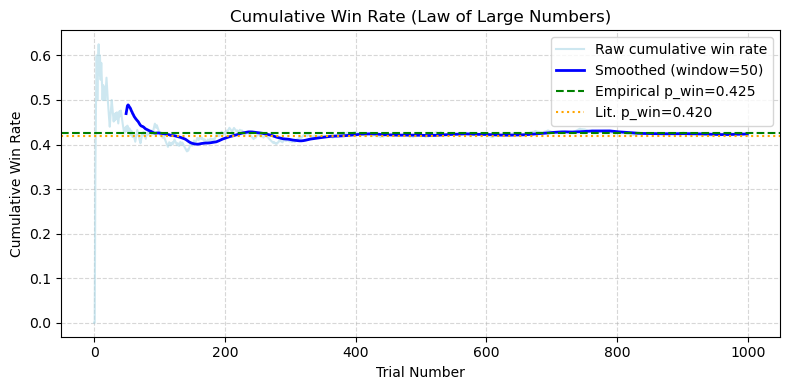

In [37]:
# Unit 2 Final Project

# If gymnasium is not installed uncomment the line below:
# !pip install gymnasium --quiet

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# Parameters

n_trials = 1000     # number of simulated games
demo_games = 5      # small text-based demo count (optional, set to 0 to skip)
stick_threshold = 17   # strategy: hit while player_sum < stick_threshold

# Helper: binomial tail probability (Pr[X >= k]) without scipy

def binomial_tail(n, p, k):
    # sum_{i=k..n} C(n,i) p^i (1-p)^(n-i)
    total = 0.0
    for i in range(k, n+1):
        total += math.comb(n, i) * (p**i) * ((1-p)**(n-i))
    return total

# Environment init

env = gym.make("Blackjack-v1", natural=False, sab=False)

# Optional: short text demo so you can "watch" a few rounds

if demo_games > 0:
    print("=== Demo rounds (text output) ===")
for g in range(demo_games):
    obs, info = env.reset()
    done = False
    print(f"\nDemo Game {g+1}")
    while not done:
        player_sum, dealer_card, usable_ace = obs
        action = 1 if player_sum < stick_threshold else 0
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        # Print the player's visible state before the next action (or final state)
        print(f"Player sum: {player_sum}, Dealer shows: {dealer_card}, Usable ace: {usable_ace}, Action: {'Hit' if action==1 else 'Stick'}")
        time.sleep(0.15)
    outcome = "WIN" if reward == 1 else "DRAW" if reward == 0 else "LOSS"
    print(f"Result: {outcome}")

# Run full simulation

rewards = []  # store reward per game (-1,0,1)
for t in range(n_trials):
    obs, info = env.reset()
    done = False
    while not done:
        player_sum, dealer_card, usable_ace = obs
        action = 1 if player_sum < stick_threshold else 0
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    rewards.append(reward)

env.close()

rewards = np.array(rewards)
wins = int(np.sum(rewards == 1))
draws = int(np.sum(rewards == 0))
losses = int(np.sum(rewards == -1))

empirical_p_win = wins / n_trials
empirical_p_draw = draws / n_trials
empirical_p_loss = losses / n_trials

# Expected value and std dev
mean_reward = np.mean(rewards)
std_reward = np.std(rewards, ddof=0)  # population std

# Cumulative win rate and smoothing (Law of Large Numbers)
cum_wins = np.cumsum((rewards == 1).astype(int))
cum_win_rate = cum_wins / (np.arange(1, n_trials+1))
# smoothing with rolling window
window = max(1, n_trials // 20)  # e.g., 50 for n_trials=1000
smoothed = np.convolve(cum_win_rate, np.ones(window)/window, mode='valid')

# Theoretical comparisons
# (1) Use a literature estimate for single-game win probability (common approximation)
theoretical_win_literature = 0.42

# (2) Binomial example: probability of winning at least 6 of 10 games
k = 6
m = 10
binom_prob_lit = binomial_tail(m, theoretical_win_literature, k)
binom_prob_emp = binomial_tail(m, empirical_p_win, k)

# Print summary results

print("\n=== Simulation Summary ===")
print(f"Trials: {n_trials}")
print(f"Wins: {wins}, Draws: {draws}, Losses: {losses}")
print(f"Empirical probabilities - Win: {empirical_p_win:.3f}, Draw: {empirical_p_draw:.3f}, Loss: {empirical_p_loss:.3f}")
print(f"Expected value (mean reward per game): {mean_reward:.3f}")
print(f"Standard deviation of rewards: {std_reward:.3f}")
print()
print(f"Theoretical (literature) single-game win prob: {theoretical_win_literature:.3f}")
print(f"P(win >= {k} of {m}) using literature p={theoretical_win_literature:.3f}: {binom_prob_lit:.3f}")
print(f"P(win >= {k} of {m}) using empirical p={empirical_p_win:.3f}: {binom_prob_emp:.3f}")

# Visuals (appear after simulation)

counts = [wins, draws, losses]
labels = ['Wins','Draws','Losses']
colors = ['green','gray','red']

plt.figure(figsize=(6,4))
bars = plt.bar(labels, counts, color=colors)
plt.title(f'Blackjack Outcomes over {n_trials} Games')
plt.ylabel('Number of Games')

# Add a comfortable y-limit so annotations never overlap or get cut
ymax = max(counts)
padding = max(3, int(n_trials * 0.03))            # at least 3, or 3% of trials
plt.ylim(0, ymax + padding)

# Annotate counts above bars with safe offset
for i, val in enumerate(counts):
    plt.text(i, val + padding * 0.2, f"{val}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Cumulative win-rate plot (raw + smoothed)
plt.figure(figsize=(8,4))
plt.plot(cum_win_rate, color='lightblue', alpha=0.6, label='Raw cumulative win rate')
plt.plot(np.arange(window-1, n_trials), smoothed, color='blue', linewidth=2, label=f'Smoothed (window={window})')
plt.axhline(y=empirical_p_win, color='green', linestyle='--', label=f'Empirical p_win={empirical_p_win:.3f}')
plt.axhline(y=theoretical_win_literature, color='orange', linestyle=':', label=f'Lit. p_win={theoretical_win_literature:.3f}')
plt.xlabel('Trial Number')
plt.ylabel('Cumulative Win Rate')
plt.title('Cumulative Win Rate (Law of Large Numbers)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Conclusion

After simulating 1,000 Blackjack games using a fixed strategy of "hit until 17, then stick," the results closely matched theoretical expectations. The simulation produced 425 wins, 107 draws, and 468 losses, resulting in an empirical win rate of 42.5%, which aligns nearly exactly with the theoretical win probability of 42% from Blackjack probability literature.

The expected value per game was -0.043, reflecting a small average loss consistent with the house edge, while the standard deviation of 0.944 indicates moderate variation across individual games.

Using a binomial probability model, the probability of winning at least 6 of 10 games was 0.202 theoretically and 0.211 empirically, confirming that the simulation accurately captures expected outcomes over multiple rounds. The cumulative win-rate plot demonstrates convergence toward the empirical mean, illustrating the Law of Large Numbers, where larger sample sizes produce more stable and predictable results.

Overall, this experiment shows that a simple, deterministic strategy in Blackjack yields results that are statistically consistent with established probability theory. The close alignment between empirical and theoretical probabilities, combined with the expected value and cumulative behavior, validates both the design of the simulation and the reliability of the results.